# Analysis of MIMIC Data

This notebook aims to preprocess the tables in MIMIC-IV and perform statistical analyses, focusing on imputing missing values, handling outliers, converting categorical variables, and conducting exploratory data analysis (EDA) with statistical tests.
All preprocessed tables are stored in the Processed_Data folder as pickle files for efficient read/write operations.

## Setup

In [1]:
# for developmental purposes 
%load_ext autoreload
%autoreload 2

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import os


# preprocessing imports
from preprocessing.preprocessor import Preprocessor
from preprocessing.utils import Utils
from config import FILE_PATHS

## Data Loading and Preprocessing <a id='Data-Loading-Preprocessing'></a>

In this section we load the preprocessed data tables and perform any additional preprocessing rquired for the analysis

Using the Preprocessor class with configured file paths, we can preprocess all the tables in MIMIC-IV. The preprocessed data is stored in a dictionary, where the keys are the table names and the values are the preprocessed DataFrames.

To note, the main preprocessing steps include:
- Converting datetime columns to datetime objects
- Computing length of stay
- Mapping categorical values to broader categories
- Imputing missing values
- Topic modeling for triage data specifically
- Conversion of dtypes to appropriate types for memory efffiency



In [3]:
# suppress warnings
pd.options.mode.chained_assignment = None

# instantiate the preprocessor class to aid cleaning the data
preprocessor = Preprocessor(FILE_PATHS)


PREPROCESS_ALL = False
PREPROCESS_SAMPLE = False

if PREPROCESS_ALL:
    preprocessor.preprocess_and_save_all()

if PREPROCESS_SAMPLE:
    preprocessor.preprocess_and_save_sample()

In [4]:
!ls ../Processed_Data/

admissions.pkl       hosp_diagnosis.pkl   prescriptions.pkl
cms_df.pkl           icd10_codes.pkl      suffolk_df.pkl
covid_diagnoses.pkl  icd9_codes.pkl       transfers.pkl
diagnosis.pkl        icu_stays.pkl        triage.pkl
diagnosis_icu_df.pkl national_df.pkl      vitalsigns.pkl
edstays.pkl          patients.pkl


In [5]:
# lets load all the tables we will need
admissions_df = pd.read_pickle("../Processed_Data/admissions.pkl")
transfers_df = pd.read_pickle("../Processed_Data/transfers.pkl")
patients_df = pd.read_pickle("../Processed_Data/patients.pkl")
hosp_diagnosis_df = pd.read_pickle('../Processed_Data/hosp_diagnosis.pkl')
ed_stays_df = pd.read_pickle("../Processed_Data/edstays.pkl")
triage_df = pd.read_pickle("../Processed_Data/triage.pkl")
diagnosis_df = pd.read_pickle("../Processed_Data/diagnosis.pkl")
vitalsigns_df = pd.read_pickle("../Processed_Data/vitalsigns.pkl")
icu_stays_df = pd.read_pickle("../Processed_Data/icu_stays.pkl")

In [6]:
# lets a good look at all our data
Utils.display_dataframes([admissions_df, transfers_df, patients_df, hosp_diagnosis_df, ed_stays_df, triage_df, diagnosis_df, vitalsigns_df, icu_stays_df], 
                         titles=['Admissions', 'Transfers', 'Patients', 'Hospital Diagnosis', 'ED Stays', 'Triage', 'Diagnosis', 'Vital Signs', 'ICU Stays'])

## Hospital (HOSP) Data

- Here we will be using the admissions and transfers tables from the MIMIC-IV dataset.

### Admissions Table

The admissions table gives information regarding a patient’s admission to the hospital. Since each unique hospital visit for a patient is assigned a unique hadm_id, the admissions table can be considered as a definition table for hadm_id. Information available includes timing information for admission and discharge, demographic information, the source of the admission, and so on.




In [7]:
Utils.print_info(admissions_df)


DataFrame Information for: Unnamed DataFrame

Shape:
  Rows: 505495, Columns: 17

Column Types:
  datetime64[ns]: 5
  int64: 3
  category: 1
  category: 1
  category: 1
  category: 1
  category: 1
  category: 1
  category: 1
  float64: 1
  bool: 1

Missing Values:
  deathtime: 496884 (98.30%)
  edregtime: 152916 (30.25%)
  edouttime: 152916 (30.25%)

Numeric Columns Summary:
         subject_id       hadm_id  hospital_expire_flag  admission_los_hours
count  5.054950e+05  5.054950e+05         505495.000000        505495.000000
mean   1.501175e+07  2.500171e+07              0.017057            79.050933
std    2.877345e+06  2.888844e+06              0.129482            65.837059
min    1.000003e+07  2.000002e+07              0.000000             0.016667
25%    1.252528e+07  2.249637e+07              0.000000            24.966667
50%    1.502065e+07  2.500443e+07              0.000000            62.416667
75%    1.750176e+07  2.750406e+07              0.000000           114.150000
max  

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,admission_los_hours,is_dead
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaT,URGENT,TRANSFER FROM HOSPITAL,HOME,Medicaid,English,WIDOWED,White/European Descent,2180-05-06 19:17:00,2180-05-06 23:30:00,0,18.866667,False
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaT,EW EMER.,EMERGENCY ROOM,HOME,Medicaid,English,WIDOWED,White/European Descent,2180-06-26 15:54:00,2180-06-26 21:31:00,0,24.366667,False
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaT,EW EMER.,EMERGENCY ROOM,HOSPICE,Medicaid,English,WIDOWED,White/European Descent,2180-08-05 20:58:00,2180-08-06 01:44:00,0,42.100000,False
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaT,EW EMER.,EMERGENCY ROOM,HOME,Medicaid,English,WIDOWED,White/European Descent,2180-07-23 05:54:00,2180-07-23 14:00:00,0,53.333333,False
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaT,EU OBSERVATION,EMERGENCY ROOM,Unknown,Medicare,English,SINGLE,White/European Descent,2160-03-03 21:55:00,2160-03-04 06:26:00,0,7.166667,False


#### Analysis of Length of Stay

- Distribution of Length of Stay


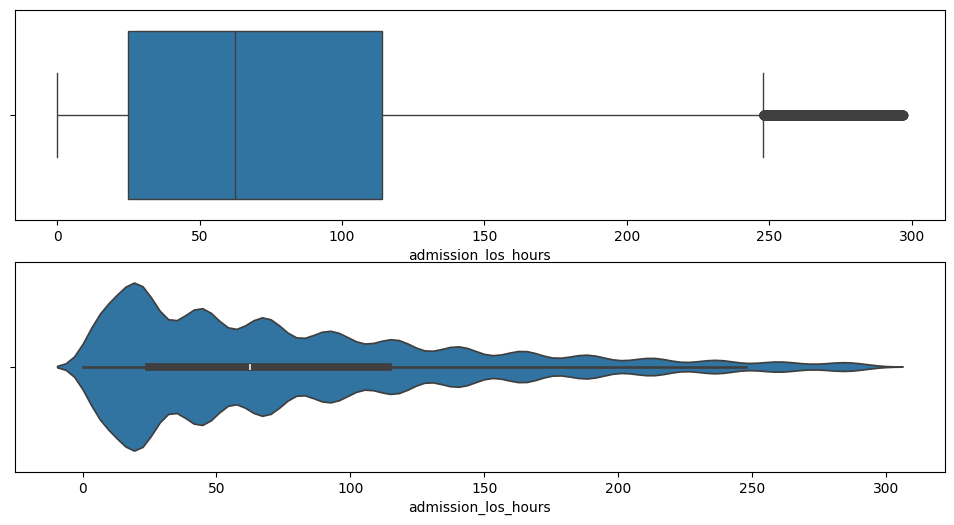

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

sns.boxplot(x = 'admission_los_hours', data = admissions_df, ax = axes[0])
sns.violinplot(x = 'admission_los_hours', data = admissions_df, ax = axes[1])
plt.savefig("../visualizations/admission-length-of-stay.png")
plt.show()

It appears theres variation every day, you can see the large peaks at the every 24 hour mark, and its with gradual diminishing every day

We can see that the IQR or 50% of the values fall between 1 to 4 days, showcasing that most patients stay within this time range. Then theres many right skewed outliers, those who stay for over 10 days at the hospital.

Comparing to the distribution of the lenght of stay for ED, it is longer as the range was about 0-16 hours most patients who go to ED stay for. We can see for the hospital the magnitude of stay duration is more in days than hours. This makes sense as the ED is for emergencies/urgent cases and would be try to be seen as quickly as possible to resolve the possible issues

#### LOS by Race Grouping

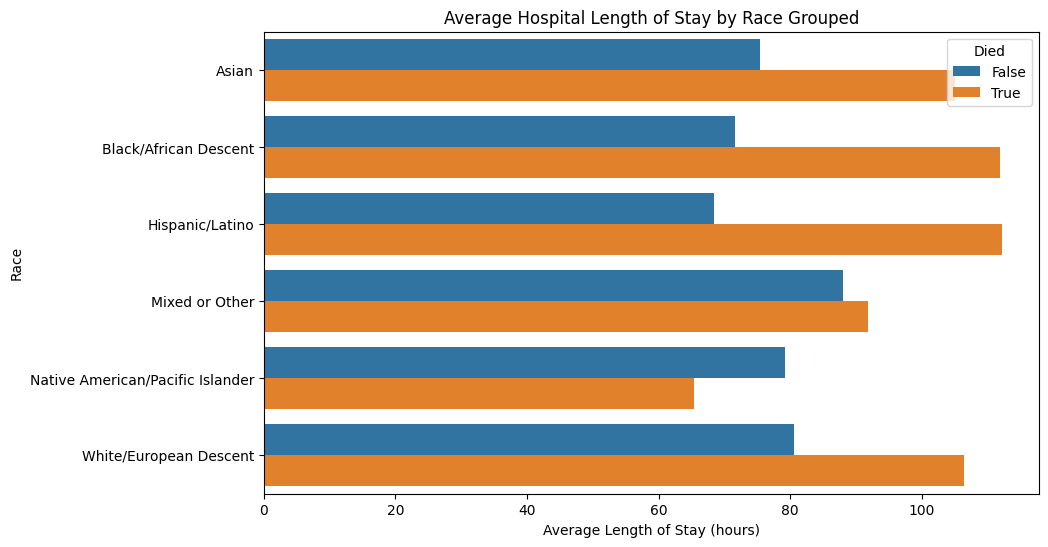

In [9]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x = 'admission_los_hours', y = 'race', hue='is_dead', data=admissions_df, orient='h', errorbar = None)
ax.legend(title='Died')
plt.title("Average Hospital Length of Stay by Race Grouped")
plt.ylabel("Race")
plt.xlabel("Average Length of Stay (hours)")
plt.show()

We observe that: 
1. Length of stay varies by race, indicating potential differences in healthcare experiences or outcomes.
2. Patients who died generally had a longer length of stay than those who survived.
3. Certain races, such as Native American/Pacific Islander and Mixed or Other, show larger differences in length of stay between survival outcomes.
4. The White/European Descent group has the longest average length of stay among those who died.
 
This suggests potential disparities in hospital experiences and outcomes, possibly warranting further investigation.

#### Mortality Rate analysis

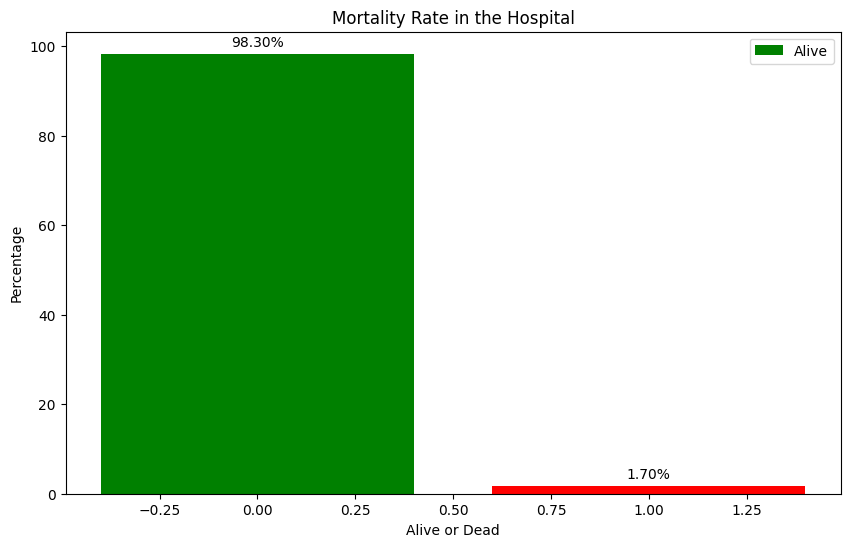

In [10]:
is_dead_counts = admissions_df['is_dead'].value_counts(normalize=True) * 100

plt.figure(figsize=(10, 6))
bars = plt.bar(is_dead_counts.index, is_dead_counts, color=['green', 'red'])
plt.title('Mortality Rate in the Hospital')
plt.xlabel('Alive or Dead')
plt.ylabel('Percentage')
plt.xticks(rotation=0)

# Add text labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}%', ha='center', va='bottom')

# Add legend
plt.legend(['Alive', 'Dead'], loc='upper right')

plt.show()

According to [National Institute of Health](https://www.ncbi.nlm.nih.gov/books/NBK588379/#:~:text=The%20number%20of%20hospitalizations%20during,from%201.9%20to%202.9%20percent.) The average annual mortality rate for hopstials is around 1-3 percent which makes it make sense

#### Mortality Rate by Insurance

We know that in the US, the topic of insurance is a major factor. Let's see if there is any relationship between mortality rate and insurance type.

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_56426/719427249.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mortality_rate = admissions_df.groupby('insurance')['is_dead'].mean().sort_values(ascending=False)
/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_56426/719427249.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mortality_rate.index, y=mortality_rate.values, palette='coolwarm', order=mortality_rate.index)


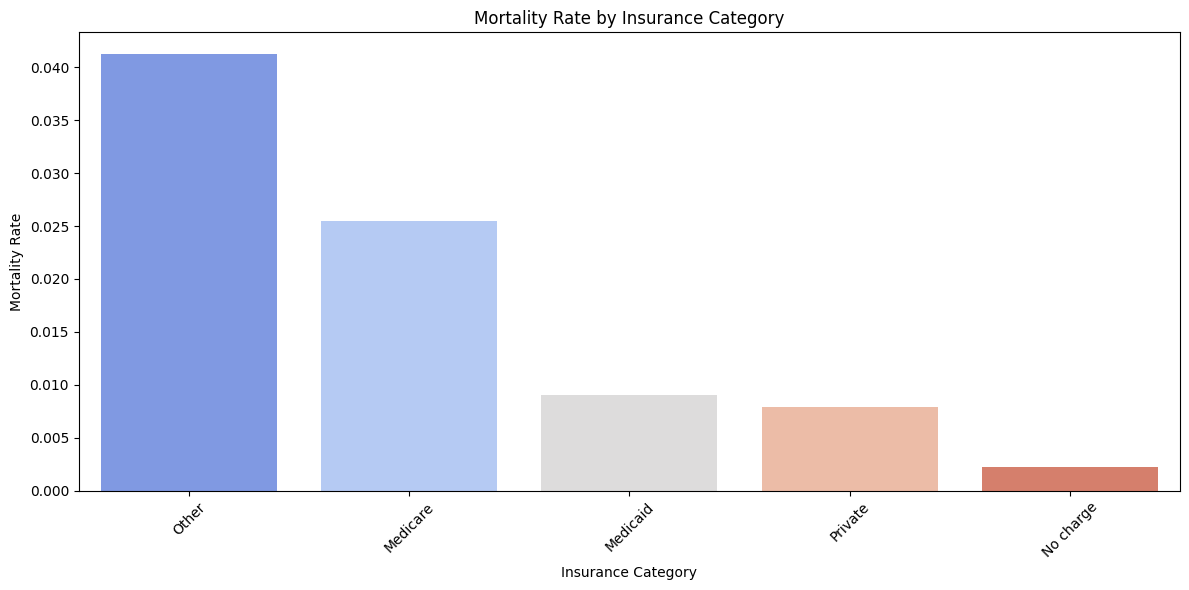

In [11]:
# Visualize mortality rate by insurance category
mortality_rate = admissions_df.groupby('insurance')['is_dead'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=mortality_rate.index, y=mortality_rate.values, palette='coolwarm', order=mortality_rate.index)
plt.title('Mortality Rate by Insurance Category')
plt.xlabel('Insurance Category')
plt.ylabel('Mortality Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Transfers Table

Physical locations for patients throughout their hospital stay.

Links to
patients on subject_id
admissions on hadm_id


The `preprocess_transfers` function cleans and preprocesses the transfers DataFrame.

1. **Parse Dates**: Converts `intime` and `outtime` columns to datetime objects for easier manipulation and calculation.

2. **Compute Length of Stay (LOS)**: Calculates the length of stay in hours, providing a useful metric for analysis.

3. **Map Care Units**: Groups care units into broader categories to simplify analysis and visualization.

4. **Convert Categorical Variables**: Converts relevant columns to categorical types to reduce memory usage and improve performance.

5. **Update Discharge Events**: Sets `outtime` to `intime` and LOS to zero for discharge events to ensure accurate data.

6. **Drop Rows with Missing LOS**: Removes rows (100 rows) with missing length of stay to maintain a clean dataset. The rows with missing length of stay may be due to data entry errors.



In [12]:
Utils.print_info(transfers_df)


DataFrame Information for: Unnamed DataFrame

Shape:
  Rows: 2413486, Columns: 9

Column Types:
  int64: 2
  float64: 2
  datetime64[ns]: 2
  category: 1
  category: 1
  category: 1

Missing Values:
  hadm_id: 408976 (16.95%)

Numeric Columns Summary:
         subject_id       hadm_id   transfer_id           los
count  2.413486e+06  2.004510e+06  2.413486e+06  2.413486e+06
mean   1.501208e+07  2.499833e+07  3.500069e+07  2.773042e+01
std    2.879273e+06  2.888195e+06  2.885852e+06  7.760738e+01
min    1.000003e+07  2.000002e+07  3.000000e+07 -2.273333e+01
25%    1.252288e+07  2.249433e+07  3.250401e+07  8.944444e-02
50%    1.502051e+07  2.499954e+07  3.500192e+07  5.233333e+00
75%    1.750674e+07  2.749853e+07  3.750178e+07  2.256472e+01
max    1.999999e+07  2.999994e+07  3.999999e+07  5.258529e+04

Categorical Columns Summary:
  eventtype:
    Unique values: 4
    Top 5 values: {'ED': 784399, 'discharge': 546024, 'admit': 545916, 'transfer': 537147}
  careunit:
    Unique values: 46


,subject_id,hadm_id,transfer_id,eventtype,careunit,intime,outtime,los,careunit_grouped
0,10000032,22595853.0,33258284,ED,Emergency Department,2180-05-06 19:17:00,2180-05-06 23:30:00,4.216667,Emergency Department
1,10000032,22595853.0,35223874,admit,Transplant,2180-05-06 23:30:00,2180-05-07 17:21:27,17.857500,Specialty Units
2,10000032,22595853.0,36904543,discharge,UNKNOWN,2180-05-07 17:21:27,2180-05-07 17:21:27,0.000000,Observation/Other
3,10000032,22841357.0,34100253,discharge,UNKNOWN,2180-06-27 18:49:12,2180-06-27 18:49:12,0.000000,Observation/Other
4,10000032,22841357.0,34703856,admit,Transplant,2180-06-26 21:31:00,2180-06-27 18:49:12,21.303333,Specialty Units


#### Distribution of Length of Stay (LOS) by Care Unit

Understand the spread of length of stay (LOS) across different care units.

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_56426/605220635.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=12)


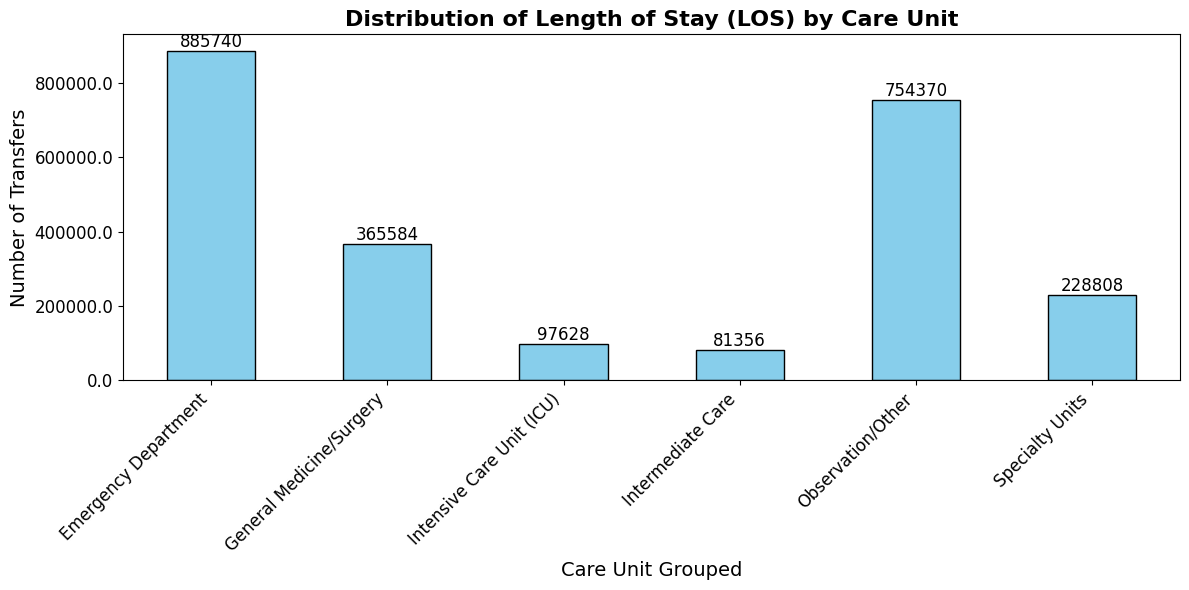

In [13]:
def visualize_los_by_careunit(transfers_df):
    plt.figure(figsize=(12, 6))
    ax = transfers_df['careunit_grouped'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
    ax.set_title('Distribution of Length of Stay (LOS) by Care Unit', fontsize=16, weight='bold')
    ax.set_xlabel('Care Unit Grouped', fontsize=14)
    ax.set_ylabel('Number of Transfers', fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
    ax.set_yticklabels(ax.get_yticks(), fontsize=12)
    
    # Add count labels above bars
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 1, f'{int(height)}', ha='center', va='bottom', fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Call the function to visualize
visualize_los_by_careunit(transfers_df)

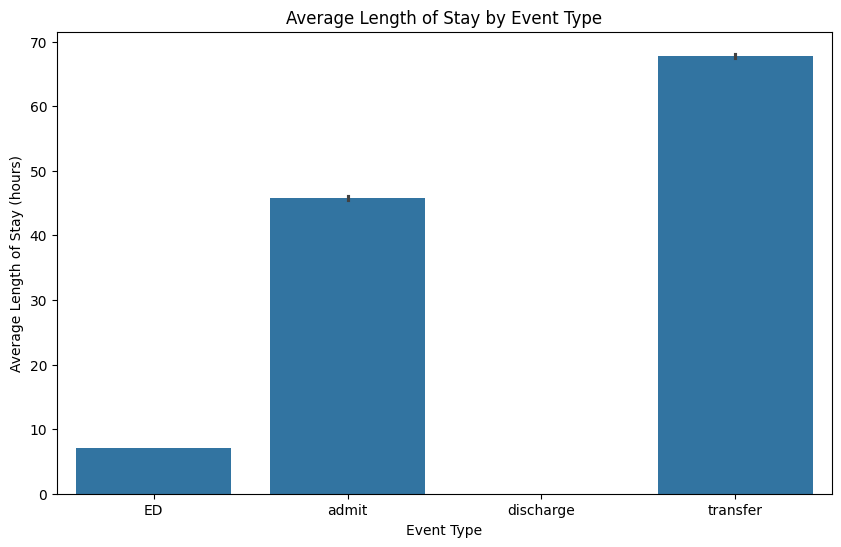

In [14]:
# LOS Comparison by Event Type
plt.figure(figsize=(10, 6))
sns.barplot(x='eventtype', y='los', data=transfers_df, estimator=np.mean)
plt.title('Average Length of Stay by Event Type')
plt.xlabel('Event Type')
plt.ylabel('Average Length of Stay (hours)')
plt.show()

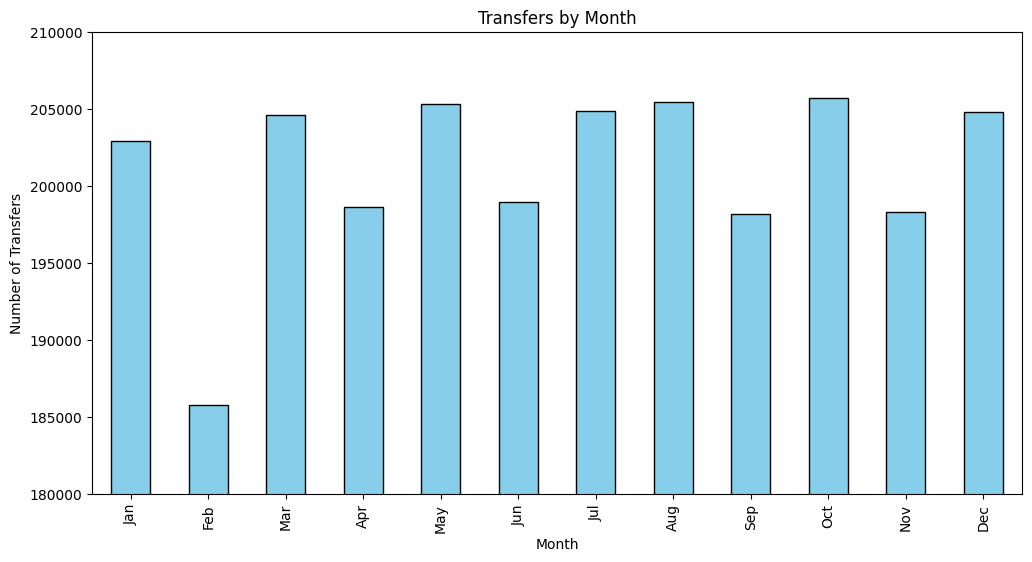

In [15]:
transfers_df['month'] = transfers_df['intime'].dt.month  # Extract month as an integer
monthly_transfers = transfers_df['month'].value_counts().sort_index()

# Plotting the number of transfers by month
plt.figure(figsize=(12, 6))
monthly_transfers.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Transfers by Month')
plt.xlabel('Month')
plt.ylabel('Number of Transfers')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylim(180000, 210000)  # Adjust the limits as needed

plt.show()

### Patients Table

Patients' gender, age, and date of death if information exists.
Information that is consistent for the lifetime of a patient is stored in this table.



In [16]:
Utils.print_info(patients_df)



DataFrame Information for: Unnamed DataFrame

Shape:
  Rows: 364627, Columns: 7

Column Types:
  int64: 3
  category: 1
  category: 1
  datetime64[ns]: 1
  bool: 1

Missing Values:
  dod: 326326 (89.50%)

Numeric Columns Summary:
         subject_id     anchor_age    anchor_year
count  3.646270e+05  364627.000000  364627.000000
mean   1.501166e+07      48.875097    2150.835404
std    2.885013e+06      20.943316      23.395666
min    1.000003e+07      18.000000    2110.000000
25%    1.251201e+07      29.000000    2131.000000
50%    1.501868e+07      48.000000    2151.000000
75%    1.750900e+07      65.000000    2171.000000
max    1.999999e+07      91.000000    2208.000000

Categorical Columns Summary:
  gender:
    Unique values: 2
    Top 5 values: {'F': 191984, 'M': 172643}
  anchor_year_group:
    Unique values: 5
    Top 5 values: {'2008 - 2010': 101607, '2011 - 2013': 76266, '2014 - 2016': 71640, '2017 - 2019': 65941, '2020 - 2022': 49173}

Sample Data:


,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod,is_dead
0,10000032,F,52,2180,2014 - 2016,2180-09-09,True
1,10000048,F,23,2126,2008 - 2010,NaT,False
2,10000058,F,33,2168,2020 - 2022,NaT,False
3,10000068,F,19,2160,2008 - 2010,NaT,False
4,10000084,M,72,2160,2017 - 2019,2161-02-13,True


/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_56426/311393163.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='anchor_year_group', data=patients_df, palette='viridis', order=sorted(patients_df['anchor_year_group'].unique()))
/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_56426/311393163.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


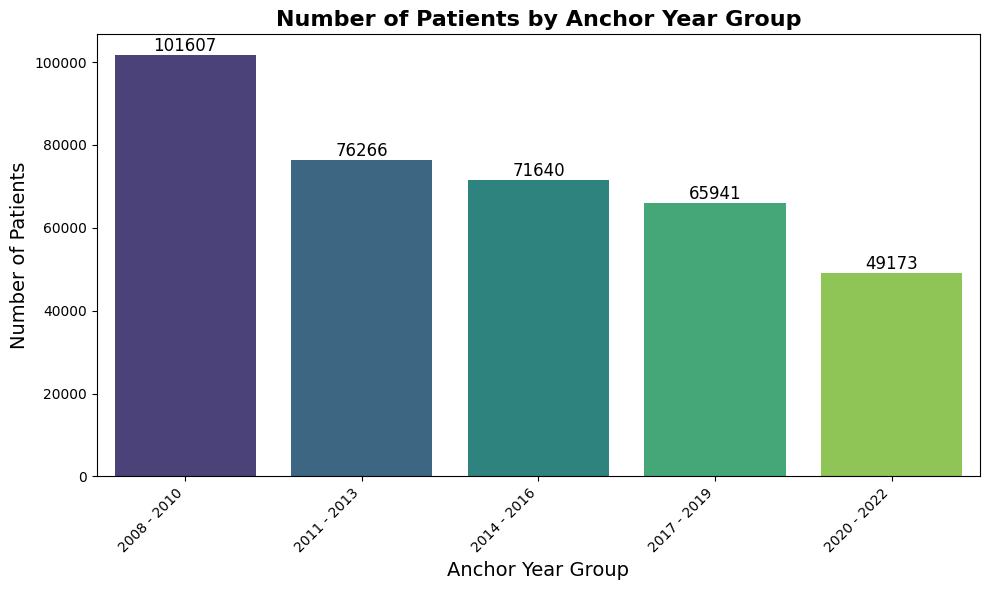

In [17]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='anchor_year_group', data=patients_df, palette='viridis', order=sorted(patients_df['anchor_year_group'].unique()))

ax.set_title('Number of Patients by Anchor Year Group', fontsize=16, weight='bold')
ax.set_xlabel('Anchor Year Group', fontsize=14)
ax.set_ylabel('Number of Patients', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Add count labels above bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 1, f'{int(height)}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

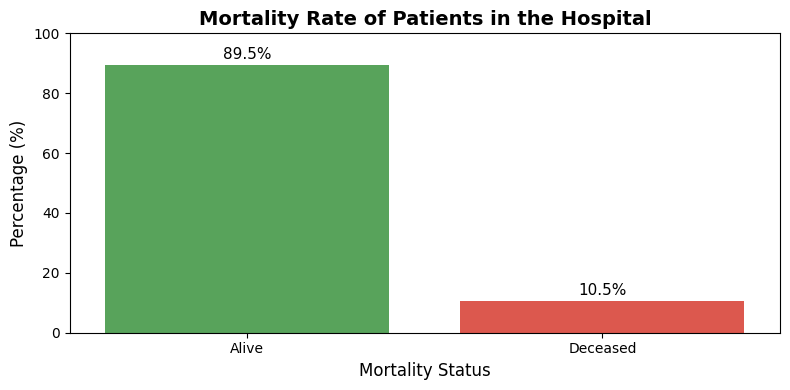

In [18]:
# Visualize mortality rate with enhanced aesthetics using seaborn
plt.figure(figsize=(8, 4))
colors = ['#4CAF50', '#F44336']  # Green for Alive, Red for Deceased
mortality_counts = patients_df.is_dead.value_counts(normalize=True) * 100
status_labels = {False: 'Alive', True: 'Deceased'}
mortality_df = mortality_counts.rename(index=status_labels).reset_index()
mortality_df.columns = ['Mortality Status', 'Percentage (%)']

ax = sns.barplot(x='Mortality Status', y='Percentage (%)', hue='Mortality Status', data=mortality_df, palette=colors, legend=False)

ax.set_title('Mortality Rate of Patients in the Hospital', fontsize=14, weight='bold')
ax.set_ylim(0, 100)
ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_xlabel('Mortality Status', fontsize=12)

# Add percentage labels above bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 1, f'{height:.1f}%', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

### Hospital Diagnosis Table

In [19]:
Utils.print_info(hosp_diagnosis_df)


DataFrame Information for: Unnamed DataFrame

Shape:
  Rows: 6364520, Columns: 7

Column Types:
  int64: 3
  category: 1
  category: 1
  category: 1
  category: 1

Missing Values:
  No missing values

Numeric Columns Summary:
         subject_id       hadm_id   icd_version
count  6.364520e+06  6.364520e+06  6.364520e+06
mean   1.500236e+07  2.500057e+07  9.542976e+00
std    2.878402e+06  2.889092e+06  4.981497e-01
min    1.000003e+07  2.000002e+07  9.000000e+00
25%    1.251029e+07  2.249519e+07  9.000000e+00
50%    1.500206e+07  2.500402e+07  1.000000e+01
75%    1.750180e+07  2.750203e+07  1.000000e+01
max    1.999999e+07  2.999994e+07  1.000000e+01

Categorical Columns Summary:
  icd_code:
    Unique values: 28562
    Top 5 values: {'4019': 102368, 'E785': 84571, 'I10': 83776, '2724': 67293, 'Z87891': 62806}
  category_code:
    Unique values: 2622
    Top 5 values: {'401': 106423, 'E87': 98690, 'E78': 97067, 'Z79': 90237, 'E11': 89084}
  category:
    Unique values: 23
    Top 5 val

,subject_id,hadm_id,icd_code,icd_version,category_code,category,subcategory
0,10000032,22595853,5723,9,572,Digestive System,Other Diseases Of Digestive System
1,10000032,22595853,78959,9,789,Symptoms & Abnormal Findings,Symptoms
2,10000032,22595853,5715,9,571,Digestive System,Other Diseases Of Digestive System
3,10000032,22595853,07070,9,070,Other,Other
4,10000032,22595853,496,9,496,Respiratory System,Chronic Obstructive Pulmonary Disease And Alli...


### Hosp Prescriptions Data

The prescriptions table provides information about prescribed medications. Information includes the name of the drug, coded identifiers including the Generic Sequence Number (GSN) and National Drug Code (NDC), the product strength, the formulary dose, and the route of administration.



## Emergency Department (ED) Data

- We will be using the ED Stays, diagnosis, triage, and vital signs t

If a subject does not have an `hadm_id`, it implies the patient visited the Emergency Department but was not subsequently admitted to the hosptial

Specifically:
1. The patient came to the ED for evaluation and treatment
2. After their ED visit, they were discharged directly from the ED rather than being admiteed as an inpatient to the hospital
3. The ED visit did not result in a hospital admission, so no hospital admission ID was generated
4. These patients could represent less severe cases that could be treated and released from the ED without requiring inpatint care
5. The patient may have been sent home, or possibly transfered to another facility, but they did not occupy an inpatient bed at the hospital associated with this ED visit

### ED Stays Table

The edstays table is the primary tracking table for emergency department visits. It provides the time the patient entered the emergency department and the time they left the emergency department.

Table source: Emergency department information system.

Table purpose: Track patient admissions to the emergency department.

Number of rows: 425,087

In [20]:
Utils.print_info(ed_stays_df)


DataFrame Information for: Unnamed DataFrame

Shape:
  Rows: 425087, Columns: 11

Column Types:
  int64: 2
  float64: 2
  datetime64[ns]: 2
  category: 1
  category: 1
  category: 1
  category: 1
  bool: 1

Missing Values:
  hadm_id: 222071 (52.24%)

Numeric Columns Summary:
         subject_id       hadm_id       stay_id   ed_los_hours
count  4.250870e+05  2.030160e+05  4.250870e+05  425087.000000
mean   1.500871e+07  2.499495e+07  3.499735e+07       7.158327
std    2.878486e+06  2.888745e+06  2.888342e+06       6.628000
min    1.000003e+07  2.000002e+07  3.000001e+07     -22.733333
25%    1.251789e+07  2.248982e+07  3.249799e+07       3.533333
50%    1.501628e+07  2.499935e+07  3.499395e+07       5.466667
75%    1.749900e+07  2.749388e+07  3.750387e+07       8.316667
max    1.999999e+07  2.999981e+07  3.999996e+07     493.069444

Categorical Columns Summary:
  gender:
    Unique values: 2
    Top 5 values: {'F': 229898, 'M': 195189}
  race:
    Unique values: 6
    Top 5 values: {'W

,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,ed_los_hours,admitted
0,10000032,22595853.0,33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,F,White/European Descent,AMBULANCE,ADMITTED,4.216667,True
1,10000032,22841357.0,38112554,2180-06-26 15:54:00,2180-06-26 21:31:00,F,White/European Descent,AMBULANCE,ADMITTED,5.616667,True
2,10000032,25742920.0,35968195,2180-08-05 20:58:00,2180-08-06 01:44:00,F,White/European Descent,AMBULANCE,ADMITTED,4.766667,True
3,10000032,29079034.0,32952584,2180-07-22 16:24:00,2180-07-23 05:54:00,F,White/European Descent,AMBULANCE,HOME,13.500000,True
4,10000032,29079034.0,39399961,2180-07-23 05:54:00,2180-07-23 14:00:00,F,White/European Descent,AMBULANCE,ADMITTED,8.100000,True


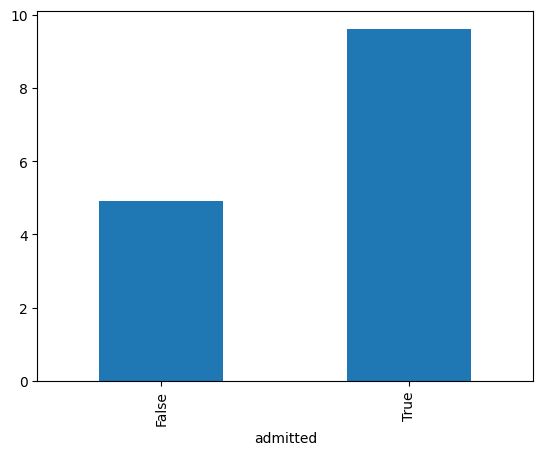

In [21]:
# ed_los_hours vs admitted 

ed_stays_df.groupby("admitted")['ed_los_hours'].mean().plot.bar()
plt.show()

### Triage Data from ED

The triage table contains information about the patient when they were first triaged in the emergency department. Patients are assessed at triage by a single care provider and asked a series of questions to assess their current health status. Their vital signs are measured and a level of acuity is assigned. Based on the level of acuity, the patient either waits in the waiting room for later attention, or is prioritized for immediate care.

In [22]:
triage_df = pd.read_pickle("../Processed_Data/triage.pkl")
Utils.print_info(triage_df)


DataFrame Information for: Unnamed DataFrame

Shape:
  Rows: 425087, Columns: 12

Column Types:
  float64: 6
  int64: 2
  object: 2
  category: 2

Missing Values:
  temperature: 23415 (5.51%)
  heartrate: 17090 (4.02%)
  resprate: 20353 (4.79%)
  o2sat: 20596 (4.85%)
  sbp: 18291 (4.30%)
  dbp: 19091 (4.49%)
  pain: 12933 (3.04%)
  acuity: 6987 (1.64%)

Numeric Columns Summary:
         subject_id       stay_id    temperature      heartrate       resprate          o2sat            sbp            dbp
count  4.250870e+05  4.250870e+05  401672.000000  407997.000000  404734.000000  404491.000000  406796.000000  405996.000000
mean   1.500871e+07  3.499735e+07      98.015046      85.079891      17.565521      98.471888     135.395352      81.262126
std    2.878486e+06  2.888342e+06       4.008575      18.041690       5.485706      17.040807     240.956408    1057.220031
min    1.000003e+07  3.000001e+07       0.100000       1.000000       0.000000       0.000000       1.000000       0.00000

,subject_id,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,topic,topic_label
0,10000032,32952584,97.8,87.0,14.0,97.0,71.0,43.0,7,2,2,Respiratory & Trauma Symptoms
1,10000032,33258284,98.4,70.0,16.0,97.0,106.0,63.0,0,3,1,General Pain & Weakness
2,10000032,35968195,99.4,105.0,18.0,96.0,106.0,57.0,10,3,5,Limb & Head Pain
3,10000032,38112554,98.9,88.0,18.0,97.0,116.0,88.0,10,3,1,General Pain & Weakness
4,10000032,39399961,98.7,77.0,16.0,98.0,96.0,50.0,13,2,1,General Pain & Weakness


### Diagnosis Data from ED

The diagnosis table provides billed diagnoses for patients. Diagnoses are determined after discharge from the emergency department.

Table source: Emergency department information system.

Table purpose: Track patient admissions to the emergency department.

Number of rows: 899,050

In [23]:
# get the table and print general information
Utils.print_info(diagnosis_df)


DataFrame Information for: Unnamed DataFrame

Shape:
  Rows: 899050, Columns: 8

Column Types:
  int64: 3
  category: 1
  object: 1
  category: 1
  category: 1
  category: 1

Missing Values:
  No missing values

Numeric Columns Summary:
         subject_id       stay_id    icd_version
count  8.990500e+05  8.990500e+05  899050.000000
mean   1.500838e+07  3.500095e+07       9.507241
std    2.879810e+06  2.888942e+06       0.499948
min    1.000003e+07  3.000001e+07       9.000000
25%    1.251347e+07  3.250347e+07       9.000000
50%    1.502022e+07  3.499600e+07      10.000000
75%    1.750406e+07  3.751290e+07      10.000000
max    1.999999e+07  3.999996e+07      10.000000

Categorical Columns Summary:
  icd_code:
    Unique values: 13199
    Top 5 values: {'4019': 26816, 'I10': 21264, 'R079': 13016, '78650': 12398, '25000': 12026}
  icd_title:
    Unique values: 13172
    Top 5 values: {'HYPERTENSION NOS': 26816, 'Essential (primary) hypertension': 21264, 'Chest pain, unspecified': 13016

,subject_id,stay_id,icd_code,icd_version,icd_title,category_code,category,subcategory
0,10000032,32952584,4589,9,HYPOTENSION NOS,458,Circulatory System,"Diseases Of Veins And Lymphatics, And Other Di..."
1,10000032,32952584,07070,9,UNSPECIFIED VIRAL HEPATITIS C WITHOUT HEPATIC ...,070,Other,Other
2,10000032,32952584,V08,9,ASYMPTOMATIC HIV INFECTION,V08,Other,Other
3,10000032,33258284,5728,9,"OTH SEQUELA, CHR LIV DIS",572,Digestive System,Other Diseases Of Digestive System
4,10000032,33258284,78959,9,OTHER ASCITES,789,Symptoms & Abnormal Findings,Symptoms


In [24]:
diagnosis_df.groupby('icd_version')['category'].value_counts().unstack(fill_value=0)

category,Blood & Immune System,Circulatory System,Congenital & Chromosomal,Digestive System,Ear & Mastoid,Endocrine & Metabolic,External Causes,Eye & Adnexa,Genitourinary System,Health Factors & Services,...,Mental & Behavioral,Musculoskeletal & Connective,Neoplasms,Nervous System,Other,Perinatal Conditions,Pregnancy & Childbirth,Respiratory System,Skin & Subcutaneous,Symptoms & Abnormal Findings
icd_version,,,,,,,,,,,,,,,,,,,,,
9,4126,49165,175,19122,0,32815,0,0,19732,0,...,23553,25751,5159,11743,76843,2,3085,15998,8622,98253
10,4612,33791,119,18755,1412,22513,27161,2596,17632,19657,...,22085,28991,1733,7424,45192,0,3404,10941,7633,131030


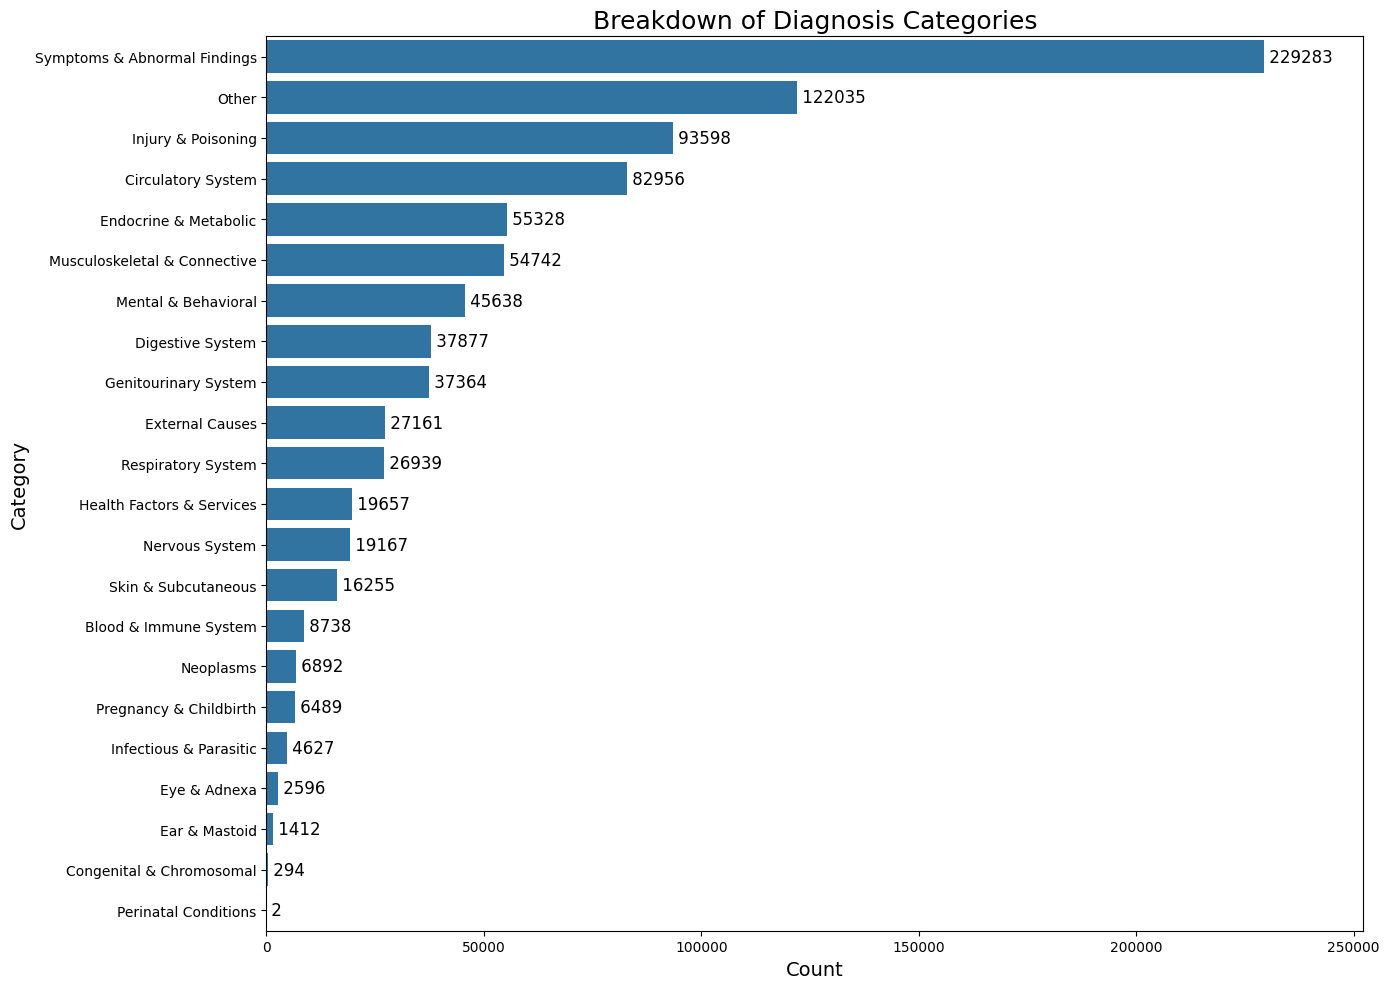

In [25]:
# breakdown diagnosis category counts with descending order
plt.figure(figsize=(14, 10))
category_counts = diagnosis_df['category'].value_counts().sort_values(ascending=False)
sns.barplot(
    x=category_counts.values, 
    y=category_counts.index, 
    orient='h', 
    order=category_counts.index
)
plt.xlim(0, category_counts.max() * 1.1)
plt.title('Breakdown of Diagnosis Categories', fontsize=18)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Category', fontsize=14)

# Add count labels to each bar for better readability
for index, value in enumerate(category_counts.values):
    plt.text(value, index, f' {value}', va='center', fontsize=12)

plt.tight_layout()
plt.show()

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_56426/2795307759.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trend_data = merged_df.groupby(['anchor_year_group', 'category']).size().reset_index(name='count')


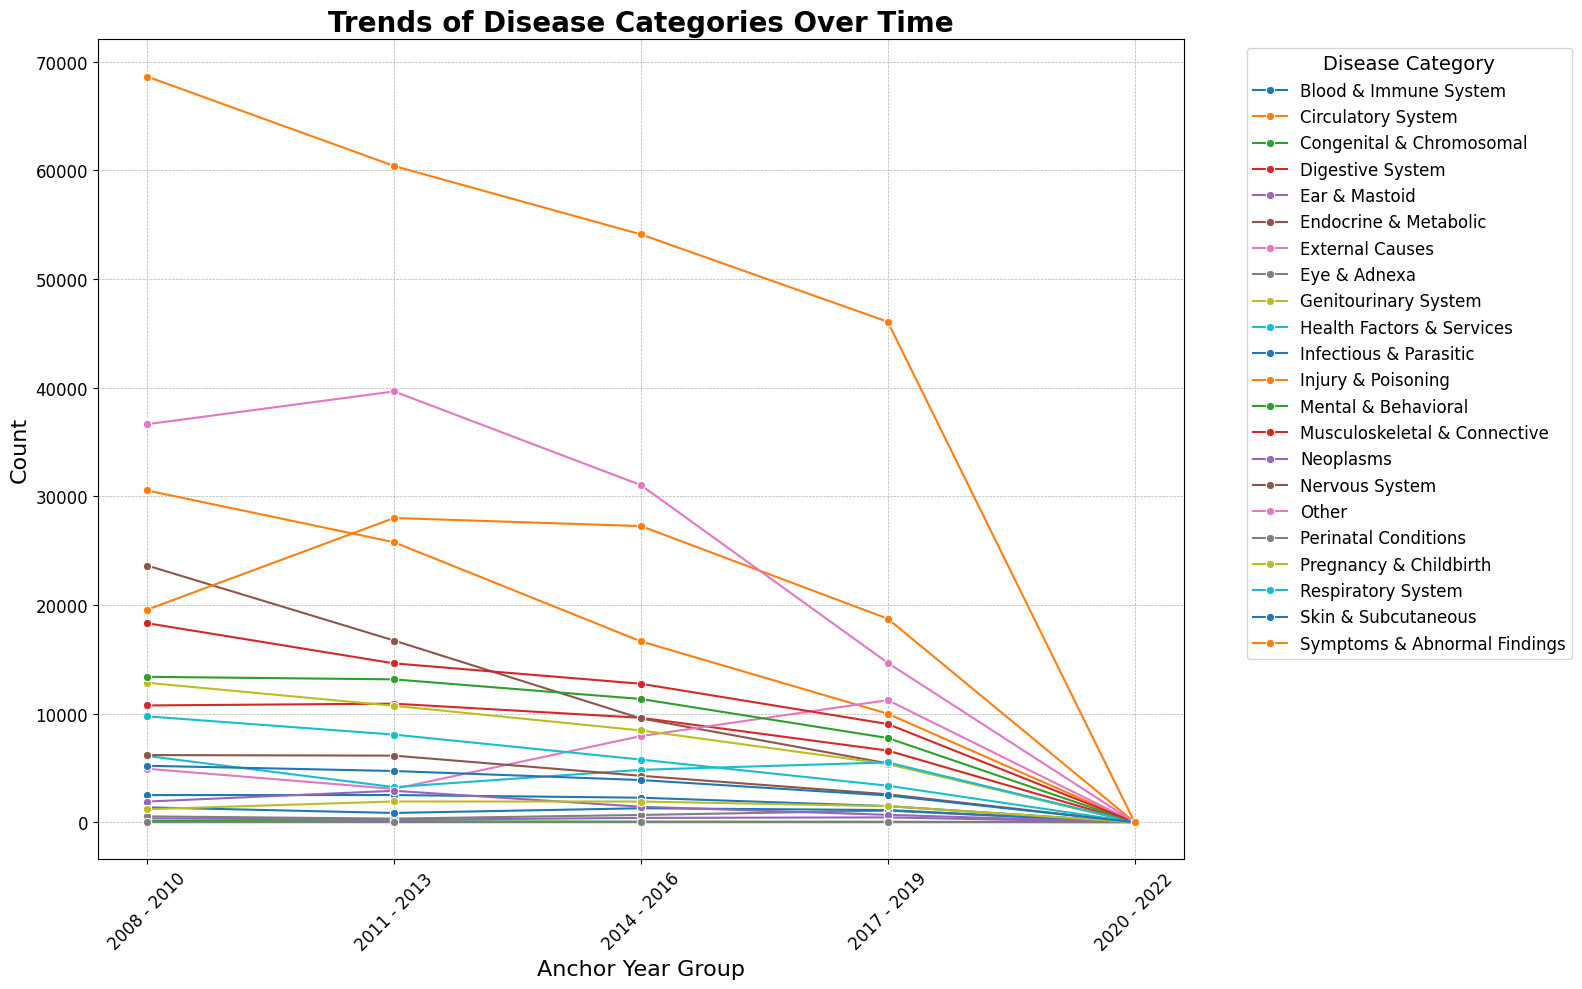

In [26]:
def plot_disease_trends(diagnosis_df, patients_df):
    # merge with patients table
    merged_df = diagnosis_df.merge(patients_df, on='subject_id', how='inner')
    merged_df.head()

    # Group the data by anchor_year_group and map_disease_category and count the occurrences
    trend_data = merged_df.groupby(['anchor_year_group', 'category']).size().reset_index(name='count')

    # Set the plot size and style
    plt.figure(figsize=(16, 10))

    # Create a line plot with enhanced visualization
    palette = sns.color_palette("tab10", n_colors=trend_data['category'].nunique())
    sns.lineplot(data=trend_data, x='anchor_year_group', y='count', hue='category', marker='o', palette=palette)

    # Customize the plot
    plt.title('Trends of Disease Categories Over Time', fontsize=20, fontweight='bold')
    plt.xlabel('Anchor Year Group', fontsize=16)
    plt.ylabel('Count', fontsize=16)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Disease Category', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage
plot_disease_trends(diagnosis_df, patients_df)

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_56426/3884110737.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mortality_data = merged_df.groupby(['anchor_year_group', 'category'])['is_dead'].mean().reset_index(name='mortality_rate')


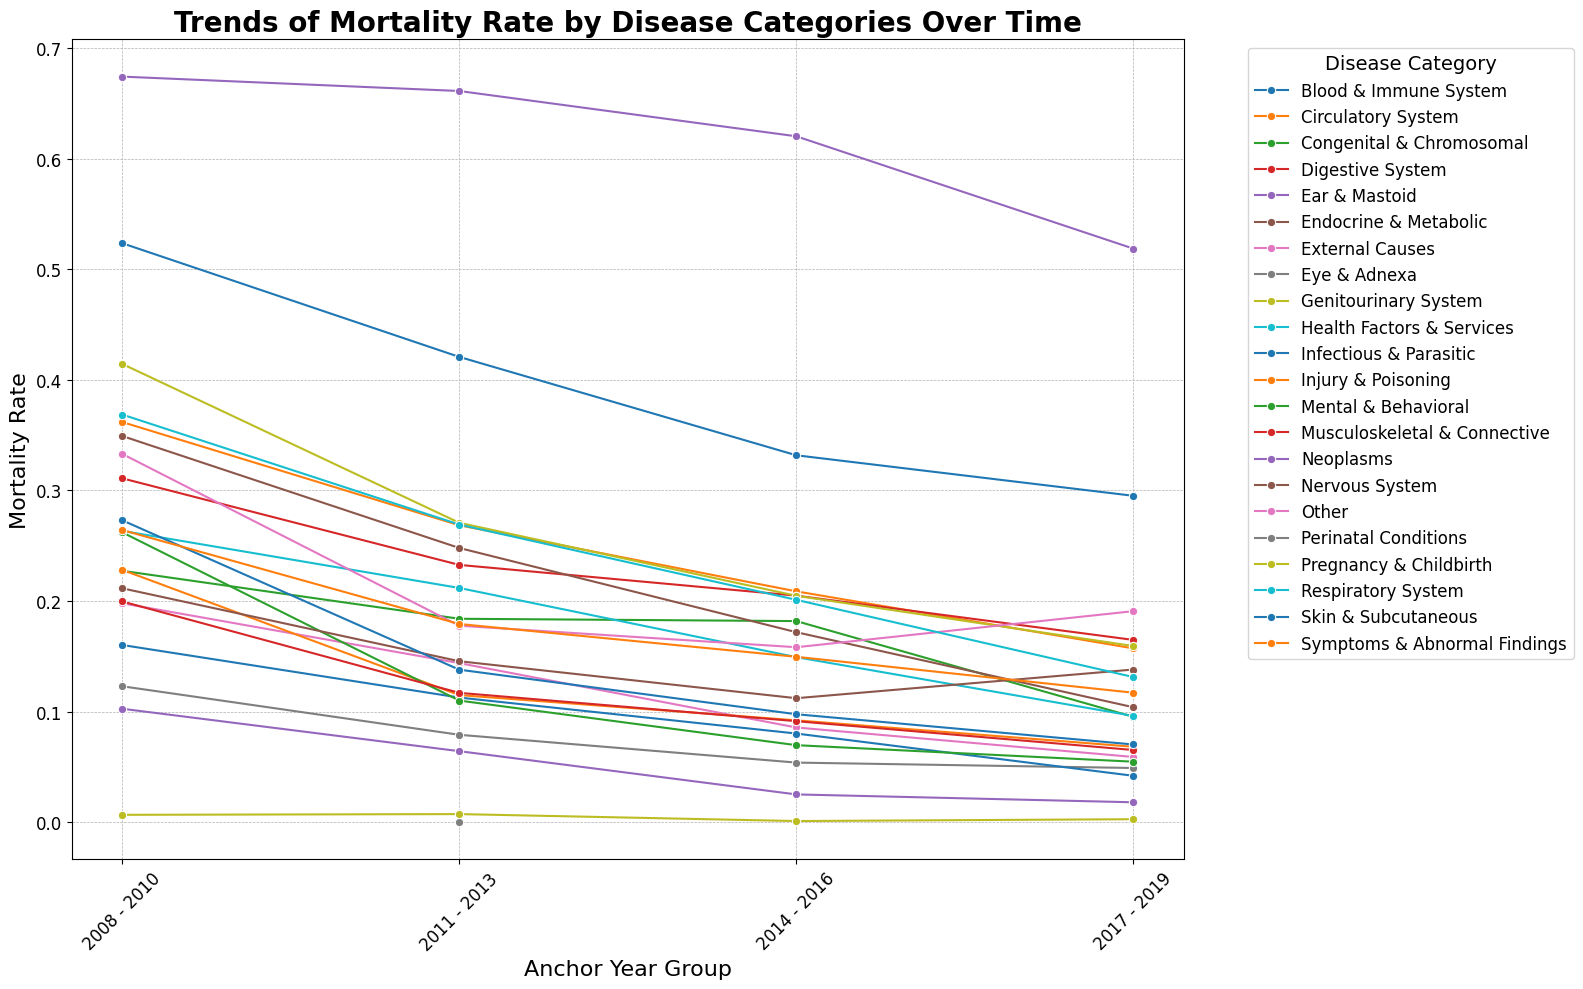

In [27]:
def plot_mortality_trends(diagnosis_df, patients_df):
    # Merge the diagnosis and patients tables
    merged_df = diagnosis_df.merge(patients_df, on='subject_id', how='inner')

    # Group the data by anchor_year_group and category, and calculate the mortality rate
    mortality_data = merged_df.groupby(['anchor_year_group', 'category'])['is_dead'].mean().reset_index(name='mortality_rate')

    # Set the plot size and style
    plt.figure(figsize=(16, 10))

    # Create a line plot with enhanced visualization
    palette = sns.color_palette("tab10", n_colors=mortality_data['category'].nunique())
    sns.lineplot(data=mortality_data, x='anchor_year_group', y='mortality_rate', hue='category', marker='o', palette=palette)

    # Customize the plot
    plt.title('Trends of Mortality Rate by Disease Categories Over Time', fontsize=20, fontweight='bold')
    plt.xlabel('Anchor Year Group', fontsize=16)
    plt.ylabel('Mortality Rate', fontsize=16)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Disease Category', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage
plot_mortality_trends(diagnosis_df, patients_df)


### Vital Signs Table

In [28]:
Utils.print_info(vitalsigns_df)


DataFrame Information for: Unnamed DataFrame

Shape:
  Rows: 925505, Columns: 11

Column Types:
  float64: 6
  object: 3
  int64: 2

Missing Values:
  rhythm: 903166 (97.59%)
  pain: 1 (0.00%)

Numeric Columns Summary:
         subject_id       stay_id    temperature      heartrate       resprate          o2sat            sbp            dbp
count  9.255050e+05  9.255050e+05  925505.000000  925505.000000  925505.000000  925505.000000  925505.000000  925505.000000
mean   1.500369e+07  3.499972e+07      98.203605      80.560228      17.393223      98.126128     129.423669      73.980850
std    2.876776e+06  2.889200e+06       0.807129      16.264764       2.454554       1.967558      20.957072      14.201292
min    1.000003e+07  3.000001e+07      95.000000      20.000000       4.000000      70.000000      50.000000      20.000000
25%    1.251208e+07  3.249773e+07      97.800000      69.000000      16.000000      97.000000     114.000000      64.000000
50%    1.501178e+07  3.499923e+07   

,subject_id,stay_id,charttime,temperature,heartrate,resprate,o2sat,sbp,dbp,rhythm,pain
4,10000032,32952584,2180-07-22 18:37:00,98.4,86.0,20.0,98.0,65.0,37.0,NaN,NaN
6,10000032,32952584,2180-07-22 19:47:00,98.2,85.0,18.0,98.0,81.0,38.0,NaN,0
7,10000032,33258284,2180-05-06 23:04:00,97.7,79.0,16.0,98.0,107.0,60.0,NaN,0
8,10000032,35968195,2180-08-05 23:50:00,98.5,96.0,17.0,100.0,102.0,58.0,NaN,0
9,10000032,35968195,2180-08-06 01:07:00,98.1,91.0,18.0,99.0,98.0,60.0,NaN,0


#### Distribution of Vital Signs

- Histograms fo each vital sign to understand their distribution across the patient population

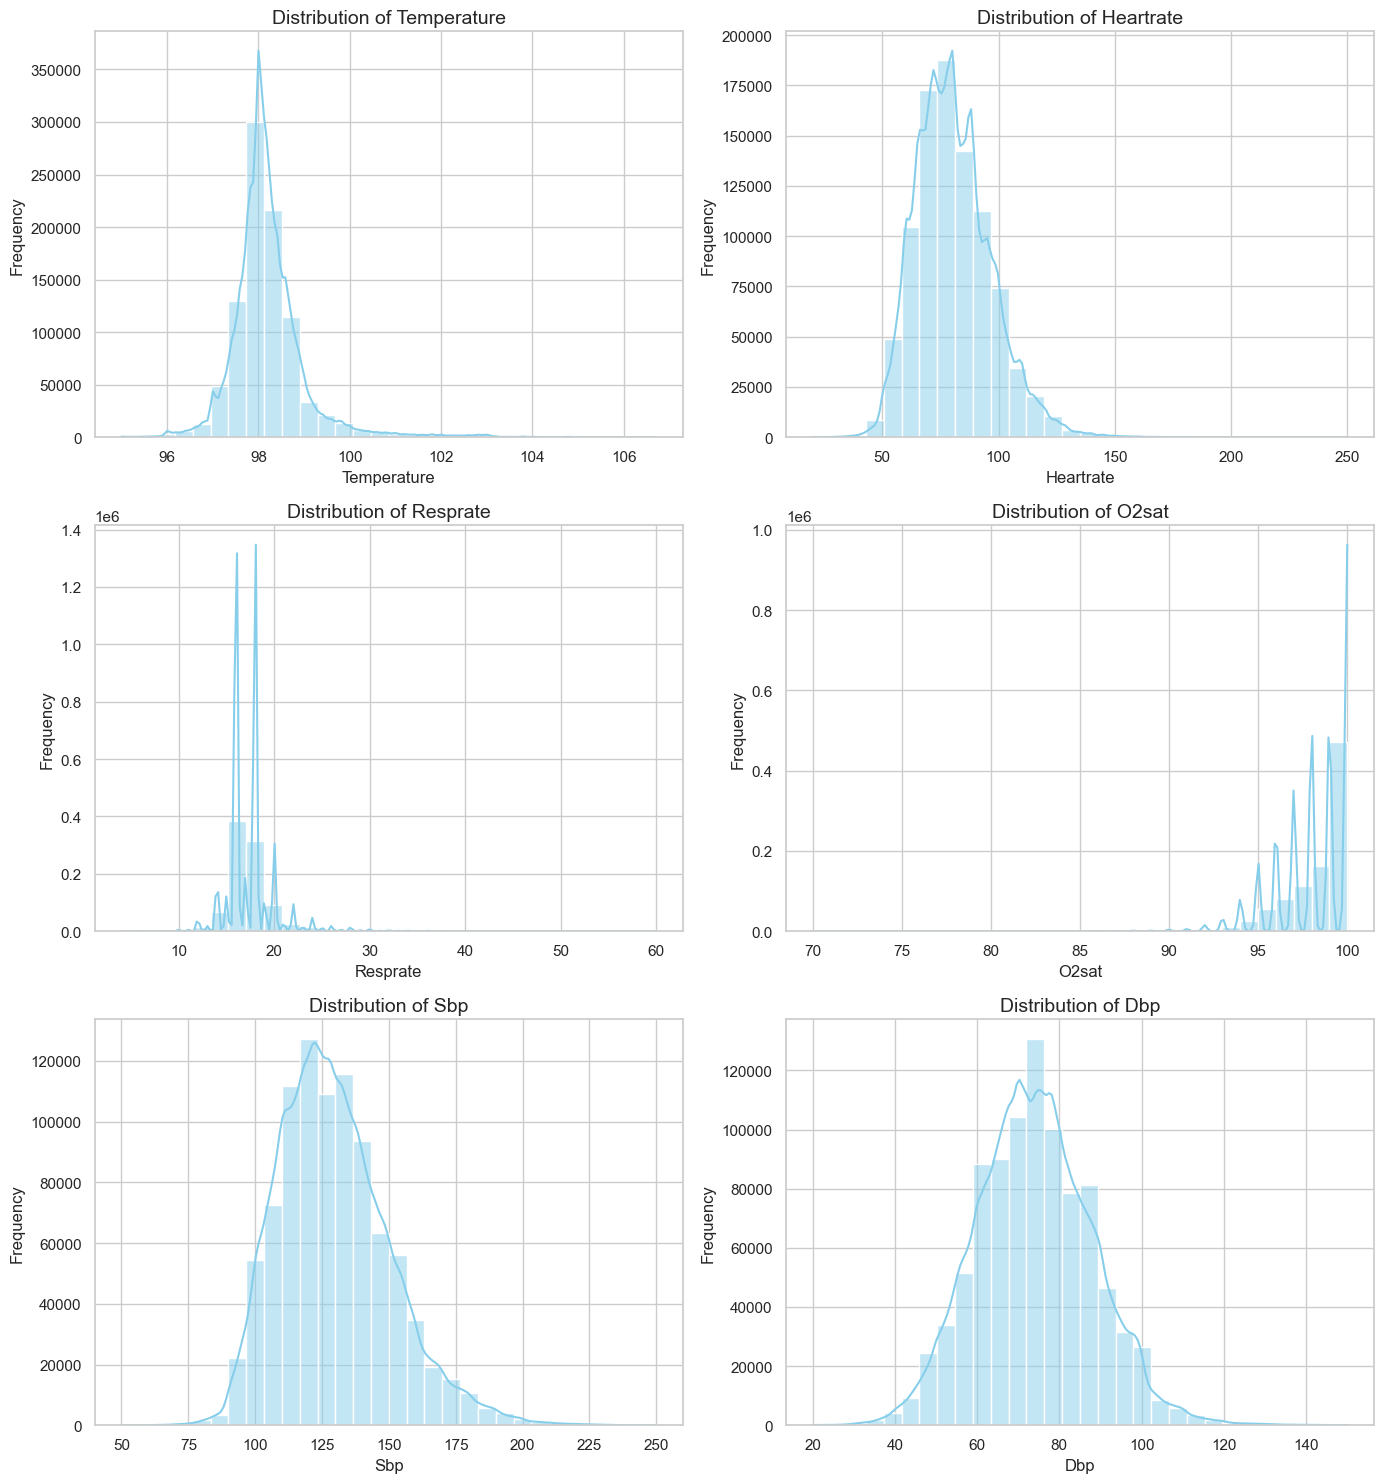

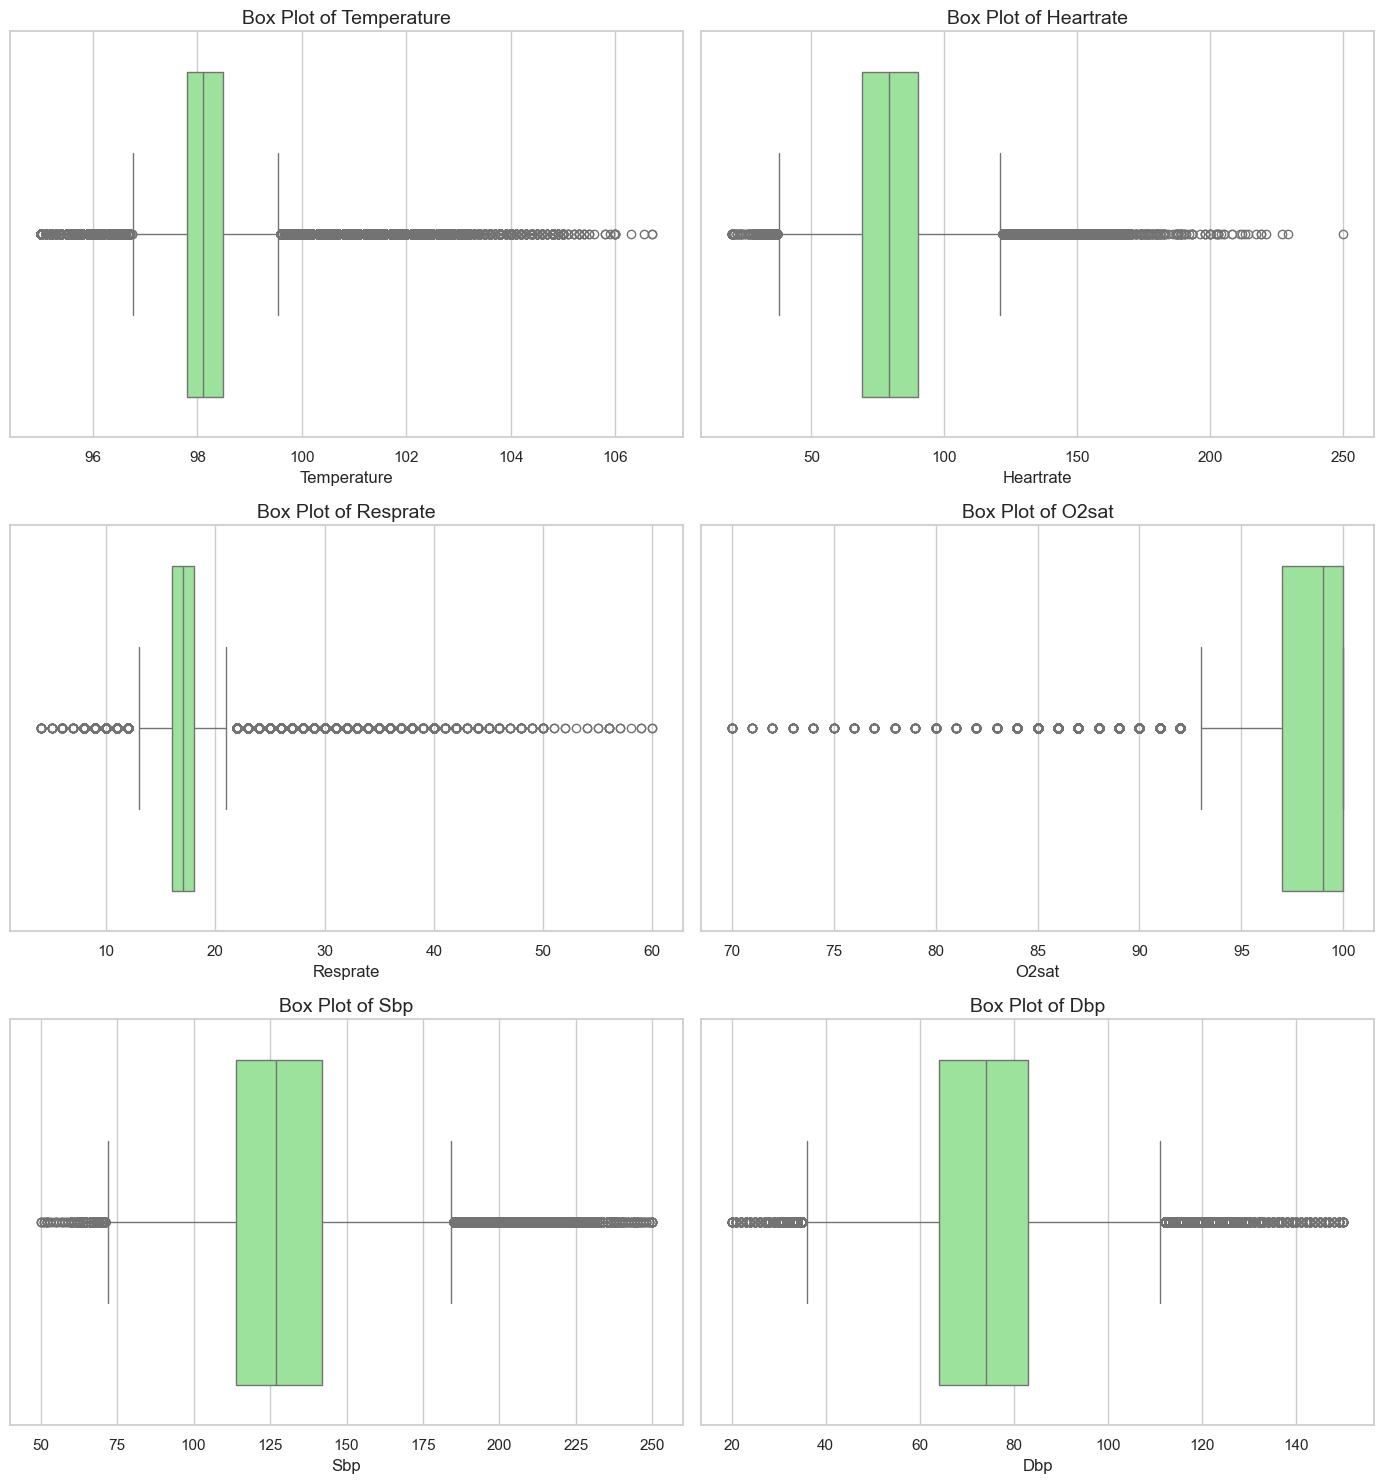

In [29]:

# List of vital sign columns
vital_signs = ['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp']

# Set the style for seaborn
sns.set(style="whitegrid")

# Histograms for each vital sign
num_vitals = len(vital_signs)
cols = 2
rows = num_vitals // cols + (num_vitals % cols > 0)

plt.figure(figsize=(14, 5 * rows))
for i, sign in enumerate(vital_signs, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(data=vitalsigns_df, x=sign, bins=30, kde=True, color='skyblue')
    plt.title(f'Distribution of {sign.capitalize()}', fontsize=14)
    plt.xlabel(f'{sign.capitalize()}', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

# Box Plots for each vital sign
plt.figure(figsize=(14, 5 * rows))
for i, sign in enumerate(vital_signs, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(x=vitalsigns_df[sign], color='lightgreen')
    plt.title(f'Box Plot of {sign.capitalize()}', fontsize=14)
    plt.xlabel(f'{sign.capitalize()}', fontsize=12)

plt.tight_layout()
plt.show()




#### Correlation 

In this section, we compute and visualize the correlation matrix for the vital signs to understand the relationships between them. We use a heatmap to display the correlation coefficients. Additionally, we create scatter plots for each pair of vital signs to further explore their relationships.



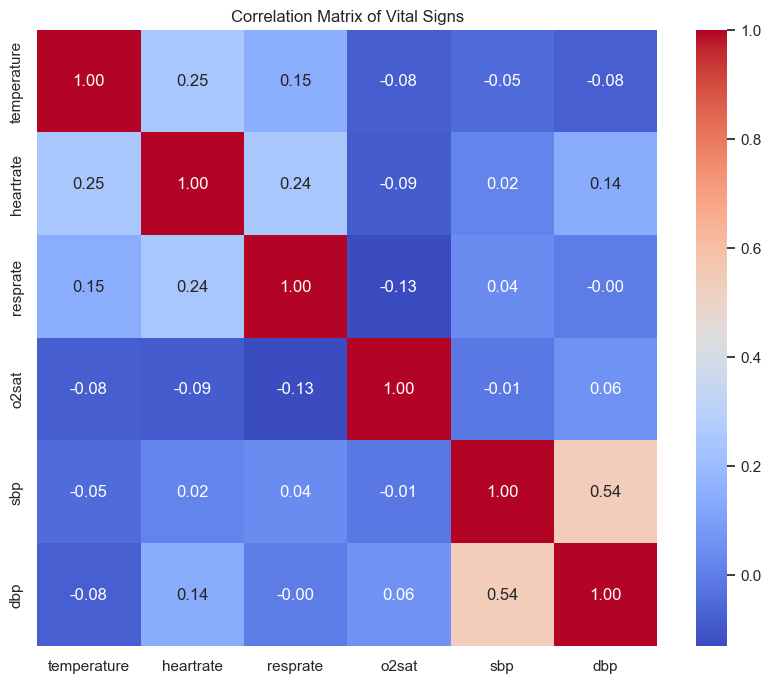

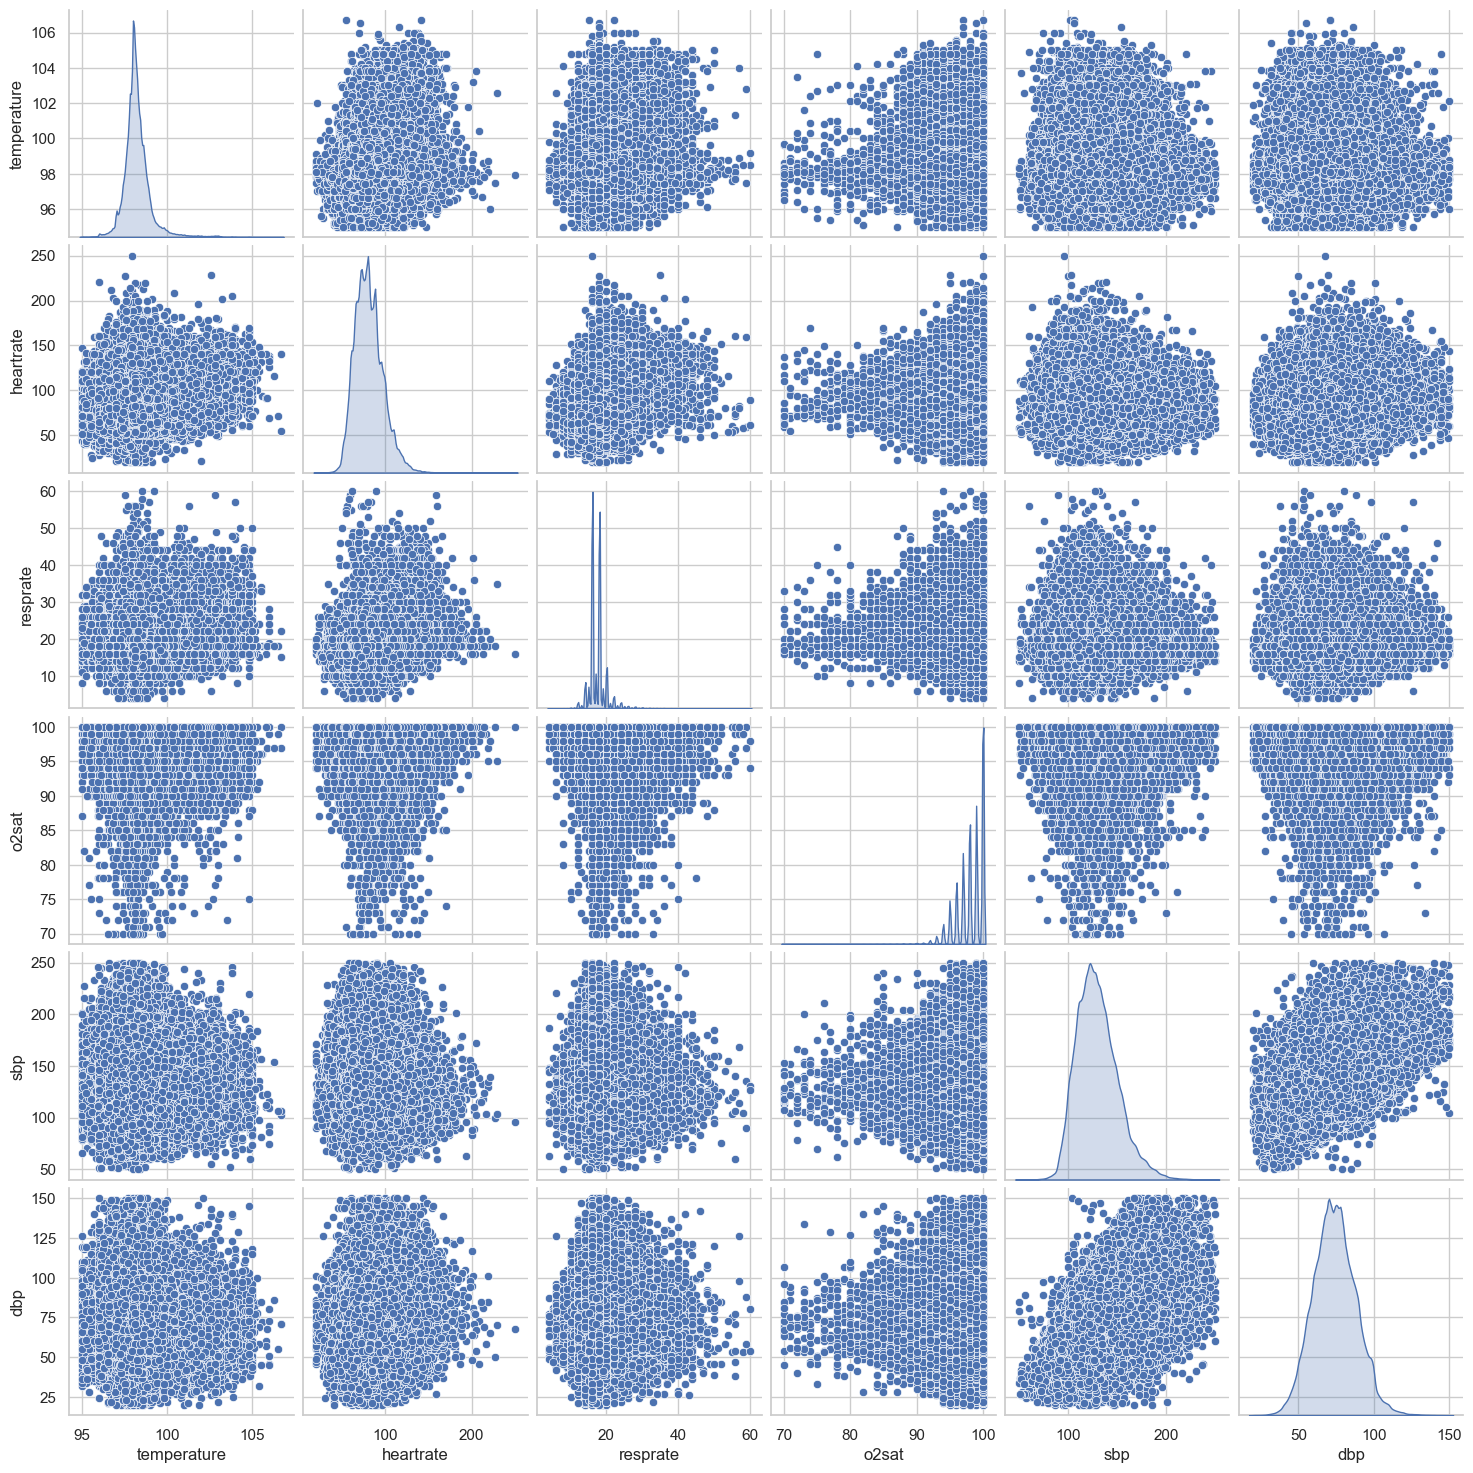

In [30]:

# Correlation Matrix
corr = vitalsigns_df[vital_signs].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Vital Signs')
plt.show()

# Scatter Plots
sns.pairplot(vitalsigns_df[vital_signs], kind='scatter', diag_kind='kde')
plt.show()




### Merging ED and Triage Tables

In [31]:
# Combining ED tables into a single dataframe
ed_stays_triage_df = ed_stays_df.merge(triage_df, on=['subject_id', 'stay_id'], how='inner')

ed_stays_triage_df.head()

,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,ed_los_hours,...,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,topic,topic_label
0,10000032,22595853.0,33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,F,White/European Descent,AMBULANCE,ADMITTED,4.216667,...,98.4,70.0,16.0,97.0,106.0,63.0,0,3,1,General Pain & Weakness
1,10000032,22841357.0,38112554,2180-06-26 15:54:00,2180-06-26 21:31:00,F,White/European Descent,AMBULANCE,ADMITTED,5.616667,...,98.9,88.0,18.0,97.0,116.0,88.0,10,3,1,General Pain & Weakness
2,10000032,25742920.0,35968195,2180-08-05 20:58:00,2180-08-06 01:44:00,F,White/European Descent,AMBULANCE,ADMITTED,4.766667,...,99.4,105.0,18.0,96.0,106.0,57.0,10,3,5,Limb & Head Pain
3,10000032,29079034.0,32952584,2180-07-22 16:24:00,2180-07-23 05:54:00,F,White/European Descent,AMBULANCE,HOME,13.500000,...,97.8,87.0,14.0,97.0,71.0,43.0,7,2,2,Respiratory & Trauma Symptoms
4,10000032,29079034.0,39399961,2180-07-23 05:54:00,2180-07-23 14:00:00,F,White/European Descent,AMBULANCE,ADMITTED,8.100000,...,98.7,77.0,16.0,98.0,96.0,50.0,13,2,1,General Pain & Weakness


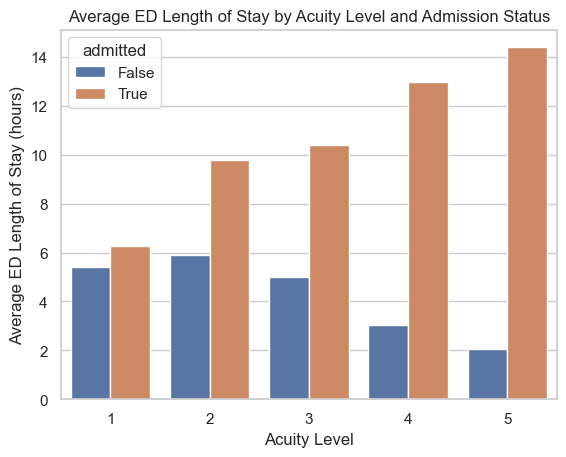

In [32]:
# bar chart of ed_los_hours by acuity level

sns.barplot(data=ed_stays_triage_df, x="acuity", y="ed_los_hours", hue="admitted", errorbar = None)
plt.title("Average ED Length of Stay by Acuity Level and Admission Status")
plt.xlabel("Acuity Level")
plt.ylabel("Average ED Length of Stay (hours)")
plt.show()

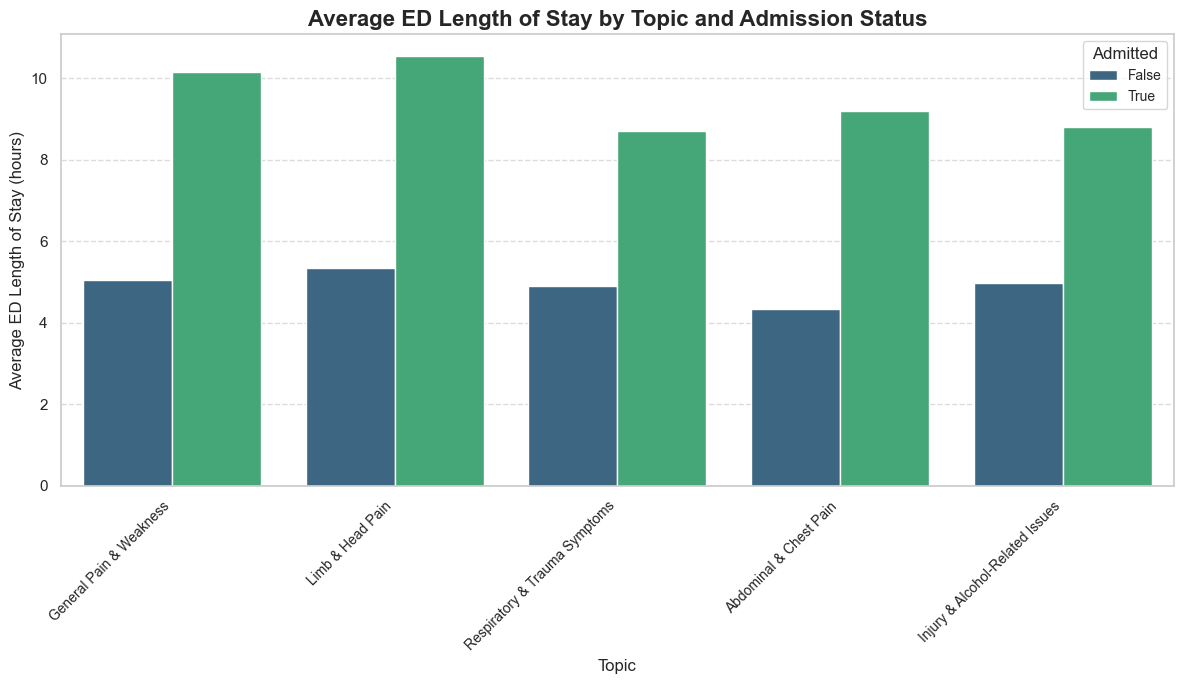

In [33]:
# Set a nice style for the plot

# Create the figure with a larger size and higher DPI for better quality
plt.figure(figsize=(12, 7), dpi=100)

# Create the bar plot with a more appealing color palette
sns.barplot(data=ed_stays_triage_df, x="topic_label", y="ed_los_hours", hue="admitted", 
            errorbar=None, palette="viridis")

# Customize the title and labels
plt.title("Average ED Length of Stay by Topic and Admission Status", fontsize=16, fontweight='bold')
plt.xlabel("Topic", fontsize=12)
plt.ylabel("Average ED Length of Stay (hours)", fontsize=12)

# Rotate and align the x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=10)

# Customize the legend
plt.legend(title="Admitted", title_fontsize='12', fontsize='10')

# Adjust the layout and add a grid for better readability
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

## ICU Data

Lets merge our ICU stays table with the patients table to add the dimensions of demographics and other variables to the ICU table

In [34]:
icu_patients_df = icu_stays_df.merge(patients_df, on='subject_id', how='inner')

In [35]:
Utils.print_info(icu_patients_df)


DataFrame Information for: Unnamed DataFrame

Shape:
  Rows: 94458, Columns: 14

Column Types:
  int64: 5
  datetime64[ns]: 3
  category: 2
  float64: 1
  category: 1
  category: 1
  bool: 1

Missing Values:
  outtime: 14 (0.01%)
  los: 14 (0.01%)
  dod: 56491 (59.81%)

Numeric Columns Summary:
         subject_id       hadm_id       stay_id           los    anchor_age   anchor_year
count  9.445800e+04  9.445800e+04  9.445800e+04  94444.000000  94458.000000  94458.000000
mean   1.500422e+07  2.498185e+07  3.499832e+07      3.630025     63.039605   2151.567776
std    2.884050e+06  2.884066e+06  2.886407e+06      5.402473     16.716605     23.541546
min    1.000003e+07  2.000009e+07  3.000015e+07      0.001250     18.000000   2110.000000
25%    1.251463e+07  2.248212e+07  3.250678e+07      1.096212     53.000000   2132.000000
50%    1.500554e+07  2.498248e+07  3.499944e+07      1.965648     65.000000   2151.000000
75%    1.751758e+07  2.746506e+07  3.749099e+07      3.862575     76.0000

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,gender,anchor_age,anchor_year,anchor_year_group,dod,is_dead
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,F,52,2180,2014 - 2016,2180-09-09,True
1,10000690,25860671,37081114,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2150-11-02 19:37:00,2150-11-06 17:03:17,3.893252,F,86,2150,2008 - 2010,2152-01-30,True
2,10000980,26913865,39765666,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535,F,73,2186,2008 - 2010,2193-08-26,True
3,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032,F,55,2157,2011 - 2013,NaT,False
4,10001217,27703517,34592300,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-12-19 15:42:24,2157-12-20 14:27:41,0.948113,F,55,2157,2011 - 2013,NaT,False


In [44]:
# convert los to los_hours
icu_patients_df['los_hours'] = icu_patients_df['los'].apply(lambda x: x * 24)

# Remove outliers
Q1 = icu_patients_df['los_hours'].quantile(0.25)
Q3 = icu_patients_df['los_hours'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_df = icu_patients_df[(icu_patients_df['los_hours'] >= lower_bound) & (icu_patients_df['los_hours'] <= upper_bound)]

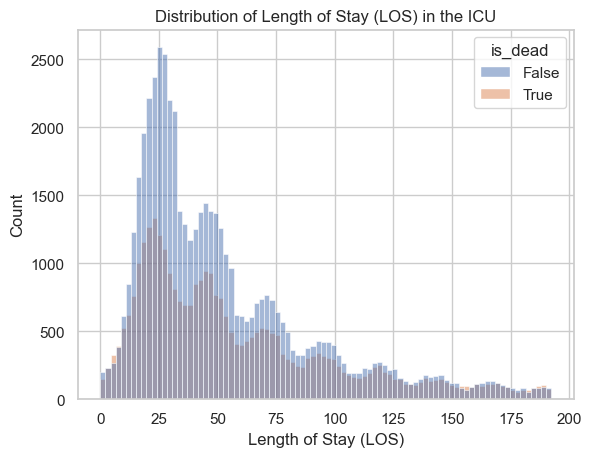

In [45]:
def visualize_los_distribution(icu_patients_df):
    # Visualize the distribution of normalized los
    sns.histplot(data=filtered_df, x='los_hours', hue='is_dead')
    plt.title('Distribution of Length of Stay (LOS) in the ICU')
    plt.xlabel('Length of Stay (LOS)')
    plt.ylabel('Count')
    plt.show()

visualize_los_distribution(filtered_df)

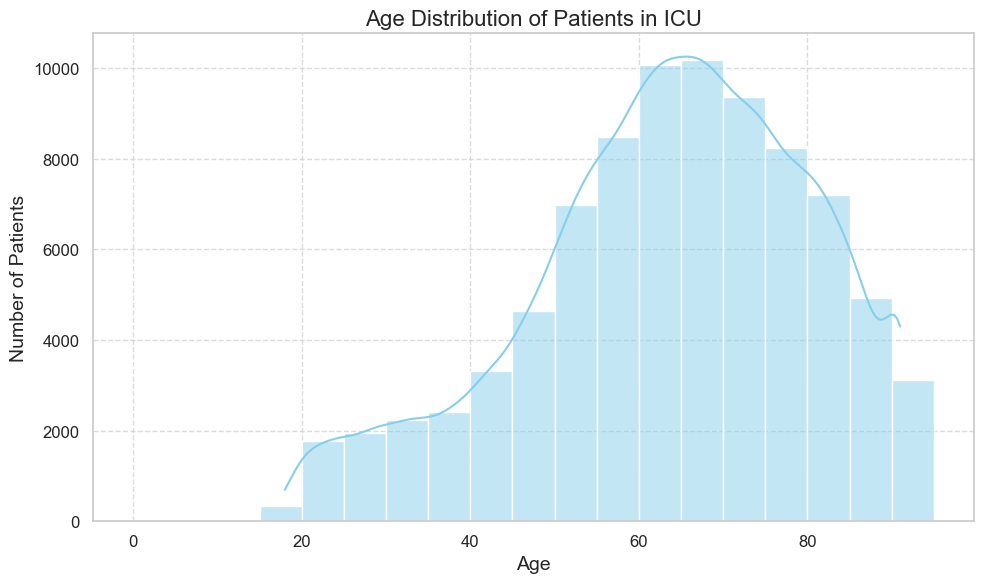

In [46]:
def visualize_age_distribution(patients_df):
    # Visualize age distribution of patients in ICU with enhanced aesthetics
    plt.figure(figsize=(10, 6))
    sns.histplot(data=patients_df, x='anchor_age', bins=np.arange(0, 100, 5), kde=True, color='skyblue')
    plt.title('Age Distribution of Patients in ICU', fontsize=16)
    plt.xlabel('Age', fontsize=14)
    plt.ylabel('Number of Patients', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

visualize_age_distribution(filtered_df)

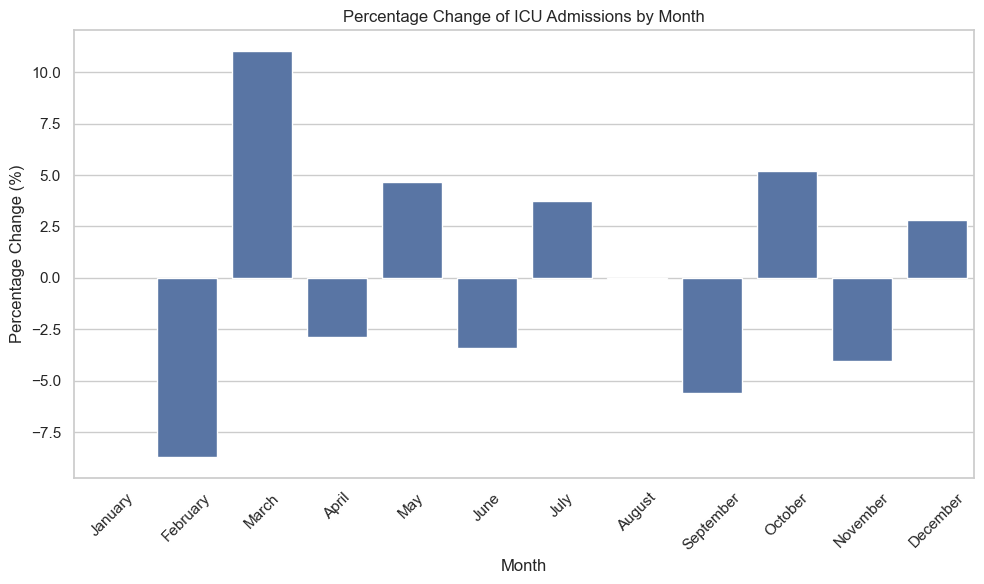

In [48]:
def monthly_analysis_with_percentage_change(filtered_df):
    # Ensure 'intime' is datetime
    filtered_df['intime'] = pd.to_datetime(filtered_df['intime'])

    # Extract month from 'intime'
    filtered_df['month'] = filtered_df['intime'].dt.month

    # Map month numbers to month names
    import calendar
    filtered_df['month_name'] = filtered_df['month'].apply(lambda x: calendar.month_name[x])

    # Count ICU admissions per month
    month_order = list(range(1, 13))
    month_counts = filtered_df['month'].value_counts().reindex(month_order)

    # Calculate percentage change by month
    month_pct_change = month_counts.pct_change() * 100

    # Plot Percentage Change in ICU admissions by month
    plt.figure(figsize=(10, 6))
    sns.barplot(x=[calendar.month_name[m] for m in month_order], y=month_pct_change.values, legend=False)
    plt.title('Percentage Change of ICU Admissions by Month')
    plt.xlabel('Month')
    plt.ylabel('Percentage Change (%)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

monthly_analysis_with_percentage_change(filtered_df)


# Summary and Conclusion

In this notebook, we performed an extensive analysis of the **MIMIC-IV** dataset, focusing on preprocessing, exploratory data analysis (EDA), and initial insights into patient admissions, transfers, diagnoses, and vital signs. The objectives were to clean and prepare the data, handle missing values and outliers, convert categorical variables, and conduct statistical analyses to uncover patterns and trends within the hospital setting.

## Data Preprocessing

Utilizing the custom `Preprocessor` class, we systematically preprocessed various tables from the MIMIC-IV dataset. Key preprocessing steps included:

- **Datetime Conversion**: Transformed date and time columns into datetime objects for accurate temporal analyses.
- **Length of Stay Calculation**: Computed the length of stay (LOS) for admissions and transfers to assess patient duration in care units.
- **Categorical Mapping**: Grouped categorical variables into broader categories to simplify analysis and improve interpretability.
- **Missing Value Imputation**: Addressed missing data to ensure robustness in statistical analyses.
- **Topic Modeling**: Applied to triage data to categorize patient chief complaints effectively.
- **Data Type Optimization**: Converted data types to appropriate formats for memory efficiency.

All preprocessed tables were stored as pickle files in the `Processed_Data` folder for efficient read/write operations.

## Exploratory Data Analysis

### Hospital Admissions

- **Length of Stay Distribution**: Most patients stayed between **1 to 4 days**, with a right-skewed distribution indicating that some patients had significantly longer stays.
- **LOS by Race**: Identified variations in LOS across different racial groups, suggesting potential disparities in healthcare experiences or outcomes. Patients who did not survive generally had a longer LOS.
- **Mortality Rate**: The hospital mortality rate aligned with national averages (~1-3%). Analysis by insurance type revealed variations in mortality rates, highlighting possible socioeconomic influences on patient outcomes.

### Transfers

- **Care Unit Distribution**: Explored the number of transfers across different care units, providing insights into patient flow within the hospital.
- **Event Type Comparison**: Compared LOS by event type, noting differences between admissions from the emergency department (ED) and other transfer types.
- **Temporal Analysis**: Examined transfers by month, observing relatively stable counts without significant seasonal variation.

### Patient Demographics

- **Anchor Year Group**: Assessed the distribution of patients over different anchor year groups, reflecting data capture periods.
- **Mortality Analysis**: Visualized overall patient mortality, with deceased patients constituting a smaller proportion of the cohort, consistent with expectations.

### Emergency Department Data

- **ED Stays**: Analyzed LOS in the ED, finding that admitted patients had longer ED stays compared to those discharged.
- **Triage Data**: Merged ED stays with triage information to evaluate LOS by acuity level and chief complaint topics derived from topic modeling.
- **Diagnosis Categories**: Identified prevalent diagnosis categories in the ED, such as "Symptoms & Abnormal Findings," providing insights into common patient presentations.
- **Disease Trends**: Tracked trends in disease categories and mortality rates over time, highlighting changes in health patterns and outcomes.

### Vital Signs

- **Distribution Analysis**: Plotted histograms and box plots for vital signs like temperature, heart rate, and blood pressure, observing their distributions across the patient population.
- **Correlation Matrix**: Computed correlations between vital signs, revealing relationships such as the positive correlation between systolic and diastolic blood pressure.

### ICU Data

- **LOS in ICU**: After removing outliers, visualized the distribution of LOS in the ICU, noting the typical duration of patient stays.
- **Age Distribution**: Examined the age distribution of ICU patients, which can inform risk stratification and resource allocation.
- **Monthly Admissions**: Investigated ICU admissions by month, calculating percentage changes to detect potential seasonal trends.

## Conclusion

The analysis provided a comprehensive overview of patient hospitalization patterns, resource utilization, and health outcomes within the MIMIC-IV dataset. Key findings include:

- **Variations in LOS**: Differences in length of stay across racial groups, insurance types, and mortality status suggest underlying factors affecting patient care and outcomes.
- **Mortality Insights**: The mortality rates observed align with national statistics, but disparities based on insurance and diagnosis categories warrant further investigation.
- **Vital Sign Relationships**: Understanding the correlations between vital signs can aid in patient monitoring and early detection of critical conditions.
- **ED and ICU Utilization**: Insights into patient flow through the ED and ICU highlight areas for operational improvement and capacity planning.

This exploratory analysis lays the groundwork for more targeted research, such as predictive modeling for patient outcomes, identifying at-risk populations, and informing policy decisions to address healthcare disparities.

## Next Steps

To enhance the scope and impact of this analysis, the following steps are planned:

1. **Integration with Global Burden of Disease (GBD) Data**:
   - **Objective**: Compare local hospital data with global health trends to contextualize findings.
   - **Benefits**:
     - Identify prevalent diseases and assess their impact on hospital admissions.
     - Benchmark hospital data against global statistics to highlight unique patterns or anomalies.
     - Inform public health strategies and resource allocation based on global disease burdens.

2. **Incorporation of CMS Monthly Medicare Enrollment Data**:
   - **Objective**: Analyze healthcare utilization among Medicare beneficiaries.
   - **Benefits**:
     - Understand patterns in hospital admissions related to the elderly and disabled populations.
     - Explore the effect of Medicare enrollment trends on hospital resource demands.
     - Assess cost implications and opportunities for optimizing care for Medicare patients.

By integrating these datasets, we aim to develop a more comprehensive model that accounts for broader demographic and epidemiological factors. This approach will enhance our ability to draw meaningful conclusions, inform policy, and ultimately contribute to improved healthcare delivery and patient outcomes.

---

**Note**: The integration of external datasets will require careful consideration of data compatibility, privacy regulations, and methodological approaches to ensure valid and actionable insights.